# CNN Experiments for classifying step 3g

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 339, in run
    requirement_set = resolver.resolve(
  File "/

In [83]:
import transformers
print(transformers.__version__)

4.26.1


# 0. Load Data

In [84]:
# load data
path = 'drive/My Drive/P8/data'
train = pd.read_csv(os.path.join(path, "train_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})
val = pd.read_csv(os.path.join(path, "val_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})
test = pd.read_csv(os.path.join(path, "test_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})

#0. Utilities

In [85]:
def create_subcorpora(step, train_df, val_df, test_df):
  """Create train, test and val corpora for the specific subnet. 
  This function prepares 3 dataframes for binary classification: 
  new label 1 = the class we want to classify in this subnet. 
  new label 0 = random samples of all other classes, size equal to length of class 1."""
  # get sample length
  n_train = len(train[train['label'] == step])
  n_val = len(val[val['label'] == step])
  n_test = len(test[test['label'] == step])
  # create subset 
  # train: keep all instances of class 5 and 400 random other rows 
  subset_train = pd.concat([
      train[train['label'] == step],  # keep all rows with label 5
      train[train['label'] != step].sample(n=n_train, random_state=42)  # sample 500 rows with other labels
  ]).dropna()
  # val: keep all instances of class 5 and 50 random other rows 
  subset_val = pd.concat([
      val[val['label'] == step],  # keep all rows with label 5
      val[val['label'] != step].sample(n=n_val, random_state=42)  # sample 500 rows with other labels
  ]).dropna()
  # test: keep all instances of class 5 and 50 random other rows
  subset_test = pd.concat([
      test[test['label'] == step],  # keep all rows with label 5
      test[test['label'] != step].sample(n=n_test, random_state=42)  # sample 500 rows with other labels
  ]).dropna()

  # create new label 
  subset_train['new_label'] = [int(1) if x == step else int(0) for x in subset_train["label"]]
  subset_val['new_label'] = [int(1) if x == step else int(0) for x in subset_val["label"]]
  subset_test['new_label'] = [int(1) if x == step else int(0) for x in subset_test["label"]]

  # drop unnecessary columns
  subset_train = subset_train.drop(["text_id", "label"], axis = 1)
  subset_val = subset_val.drop(["text_id", "label"], axis = 1)
  subset_test = subset_test.drop(["text_id", "label"], axis = 1)

  return subset_train, subset_val, subset_test

In [99]:
# get target and sentences for a dataframe
def get_target_sentence(df):
  """input: dataframe that contains sentences and labels.
  output: labels as pandas.core.series.Series & sentences as list"""
  labels = df.pop("new_label").to_numpy()
  sentences = df["sentence"].to_list() # list
  return sentences, labels

In [124]:
# prepare function to check for overfitting
# check for overfitting
def plot_result(history):
  plt.plot(history.history['accuracy'], label ="Training accuracy")
  plt.plot(history.history['val_accuracy'], label ="Validation accuracy")
  plt.title("Accuracy of baseline model on step 3g")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()
  return plt

In [134]:
# classification report
from sklearn.metrics import classification_report

def evaluation_report(model, X_test, y_true):
  """Returns precision, recall, fq. 
  model = the model we want to evaluate; test_data = depends on the 
  classification task (e.g. test_data_3g)."""

  # Make predictions on the test data
  y_pred = model.predict(X_test)
  y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

  report = classification_report(y_true, y_pred_classes)
  return report

# 1. Prepare Dataset



## 1.1. Create Sub-Dataset for classifying Step 3g

In [105]:
# new labels: 1 = step 3g, 0 = not step 3g
train_3g, val_3g, test_3g = create_subcorpora("3g", train, val, test)

In [106]:
# get target and sentences for each sub-frame
sentences_train, labels_train = get_target_sentence(train_3g)
sentences_val, labels_val = get_target_sentence(val_3g)
sentences_test, labels_test = get_target_sentence(test_3g)

### 1.2. Bert Embedding

In [107]:
# load encoder and embedding
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # convert text to numerical values
bert_embedding_model = TFBertModel.from_pretrained("bert-base-uncased") # generate contextualized embeddings
text = "Replace me by any text you'd like."
encoded_input = bert_tokenizer(text, return_tensors='tf') 
output = bert_embedding_model(encoded_input)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [108]:
# function to encode input data
def encode_sentences(sentences):
  """Take a list of sentences and return pretrained sentence embeddings"""
  encoded_sentences = bert_tokenizer(sentences, padding=True, truncation=True, return_tensors='tf')['input_ids']
  embedded_sentences = bert_embedding_model(encoded_sentences)[0]
  return embedded_sentences

In [109]:
# encode input data
sentences_train_embedded = encode_sentences(sentences_train)
sentences_val_embedded = encode_sentences(sentences_val)
sentences_test_embedded = encode_sentences(sentences_test)

In [113]:
print(sentences_train_embedded.shape)
print(sentences_val_embedded.shape)
print(sentences_test_embedded.shape)

(584, 143, 768)
(186, 113, 768)
(184, 110, 768)


the model expects input tensors of shape (None, 143, 768) (i.e., batches of 3D tensors with 143 timesteps and 768 features)

In [114]:
# pad all data for cnn
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad the sequences with zeros to ensure they all have the same length
MAX_SEQ_LENGTH = 143
sentences_train_padded = pad_sequences(sentences_train_embedded, maxlen=MAX_SEQ_LENGTH, padding='post')
sentences_val_padded = pad_sequences(sentences_val_embedded, maxlen=MAX_SEQ_LENGTH, padding='post')
sentences_test_padded = pad_sequences(sentences_test_embedded, maxlen=MAX_SEQ_LENGTH, padding='post')

In [119]:
print(sentences_train_padded.shape)
print(sentences_val_padded.shape)
print(sentences_test_padded.shape)

(584, 143, 768)
(186, 143, 768)
(184, 143, 768)


# 2. Build Model

In [120]:
model_cnn_bert_embeddings = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sentences_train_padded.shape[1], sentences_train_padded.shape[2])),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn_bert_embeddings.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [121]:
model_cnn_bert_embeddings.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 139, 128)          491648    
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 10)                1290      
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 492,949
Trainable params: 492,949
Non-trainable params: 0
_________________________________________________________________


# 3. Train Model

In [128]:
history_cnn_bert_embeddings = model_cnn_bert_embeddings.fit(sentences_train_padded, labels_train, 
                                              epochs=6, 
                                              batch_size=32, 
                                              validation_data=(sentences_val_padded, labels_val))

Epoch 1/6
19/19 [==============================] - 7s 367ms/step - loss: 0.0750 - accuracy: 0.9983 - val_loss: 0.2921 - val_accuracy: 0.9032
Epoch 2/6
19/19 [==============================] - 9s 455ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.2612 - val_accuracy: 0.9032
Epoch 3/6
19/19 [==============================] - 5s 277ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2493 - val_accuracy: 0.9140
Epoch 4/6
19/19 [==============================] - 4s 200ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9086
Epoch 5/6
19/19 [==============================] - 5s 269ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2427 - val_accuracy: 0.9032
Epoch 6/6
19/19 [==============================] - 3s 173ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2382 - val_accuracy: 0.9086


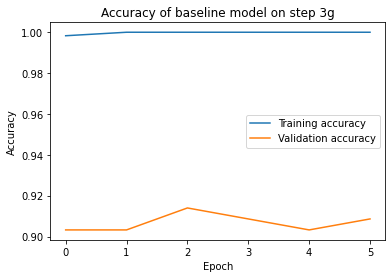

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [129]:
# check for overfitting
plot_result(history_cnn_bert_embeddings)

# 4. Evaluate Model

In [133]:
# evaluate on test data: accuracy?
loss, accuracy = model_cnn_bert_embeddings.evaluate(sentences_test_padded, labels_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

6/6 [==============================] - 1s 152ms/step - loss: 0.2283 - accuracy: 0.9293
Test loss: 0.22834263741970062
Test accuracy: 0.929347813129425


In [136]:
# precision, accuracy, f1
print(evaluation_report(model_cnn_bert_embeddings, sentences_test_padded, labels_test))

6/6 [==============================] - 1s 98ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        92
           1       0.94      0.91      0.93        92

    accuracy                           0.93       184
   macro avg       0.93      0.93      0.93       184
weighted avg       0.93      0.93      0.93       184



In [ ]:
# classification report
from sklearn.metrics import classification_report

def evaluation_report(model, X_test, y_true):
  """Returns precision, recall, fq. 
  model = the model we want to evaluate; test_data = depends on the 
  classification task (e.g. test_data_3g)."""

  # Make predictions on the test data
  y_pred = model.predict(X_test)
  y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

  report = classification_report(y_true, y_pred_classes)
  return report

6/6 [==============================] - 1s 99ms/step


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


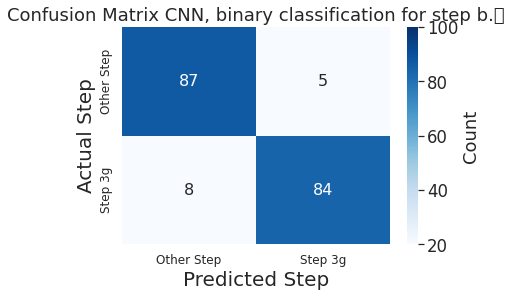

In [139]:
# confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
y_pred = model_cnn_bert_embeddings.predict(sentences_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

cm = confusion_matrix(labels_test, y_pred_classes)

new_label_dict = {
    1: "Step 3b", 
    0: "Other step"
}

sn.set(font_scale=1.5)
labels = ['Other Step', 'Step 3g']
fontdict = {'fontsize': 20}
ax = sn.heatmap(cm, cmap=plt.cm.Blues, vmin=20, vmax=100, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'}, annot_kws={"size": 16}) 
ax.set_xlabel('Predicted Step', fontdict=fontdict)
ax.set_ylabel('Actual Step', fontdict=fontdict)
ax.set_title('Confusion Matrix CNN, binary classification for step b.\b')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()